
📂 [1d] 2020~2024년 데이터 로드 및 병합 시작...
   -> 로드 중: BTCUSDT_1d_2020.csv
   -> 로드 중: BTCUSDT_1d_2021.csv
   -> 로드 중: BTCUSDT_1d_2022.csv
   -> 로드 중: BTCUSDT_1d_2023.csv
   -> 로드 중: BTCUSDT_1d_2024.csv
   -> Log Return 계산 중... (데이터 크기: 1,827 행)
🎨 [Daily] 그래프 생성 중 (총 5년치)...
   💾 저장 완료: BTC_5Year_Trend_Daily.png
--------------------------------------------------

📂 [10m] 2020~2024년 데이터 로드 및 병합 시작...
   -> 로드 중: BTCUSDT_10m_2020.csv
   -> 로드 중: BTCUSDT_10m_2021.csv
   -> 로드 중: BTCUSDT_10m_2022.csv
   -> 로드 중: BTCUSDT_10m_2023.csv
   -> 로드 중: BTCUSDT_10m_2024.csv
   -> Log Return 계산 중... (데이터 크기: 263,088 행)
🎨 [10-Min] 그래프 생성 중 (총 5년치)...
   💾 저장 완료: BTC_5Year_Trend_10min.png

✅ 모든 작업 완료!


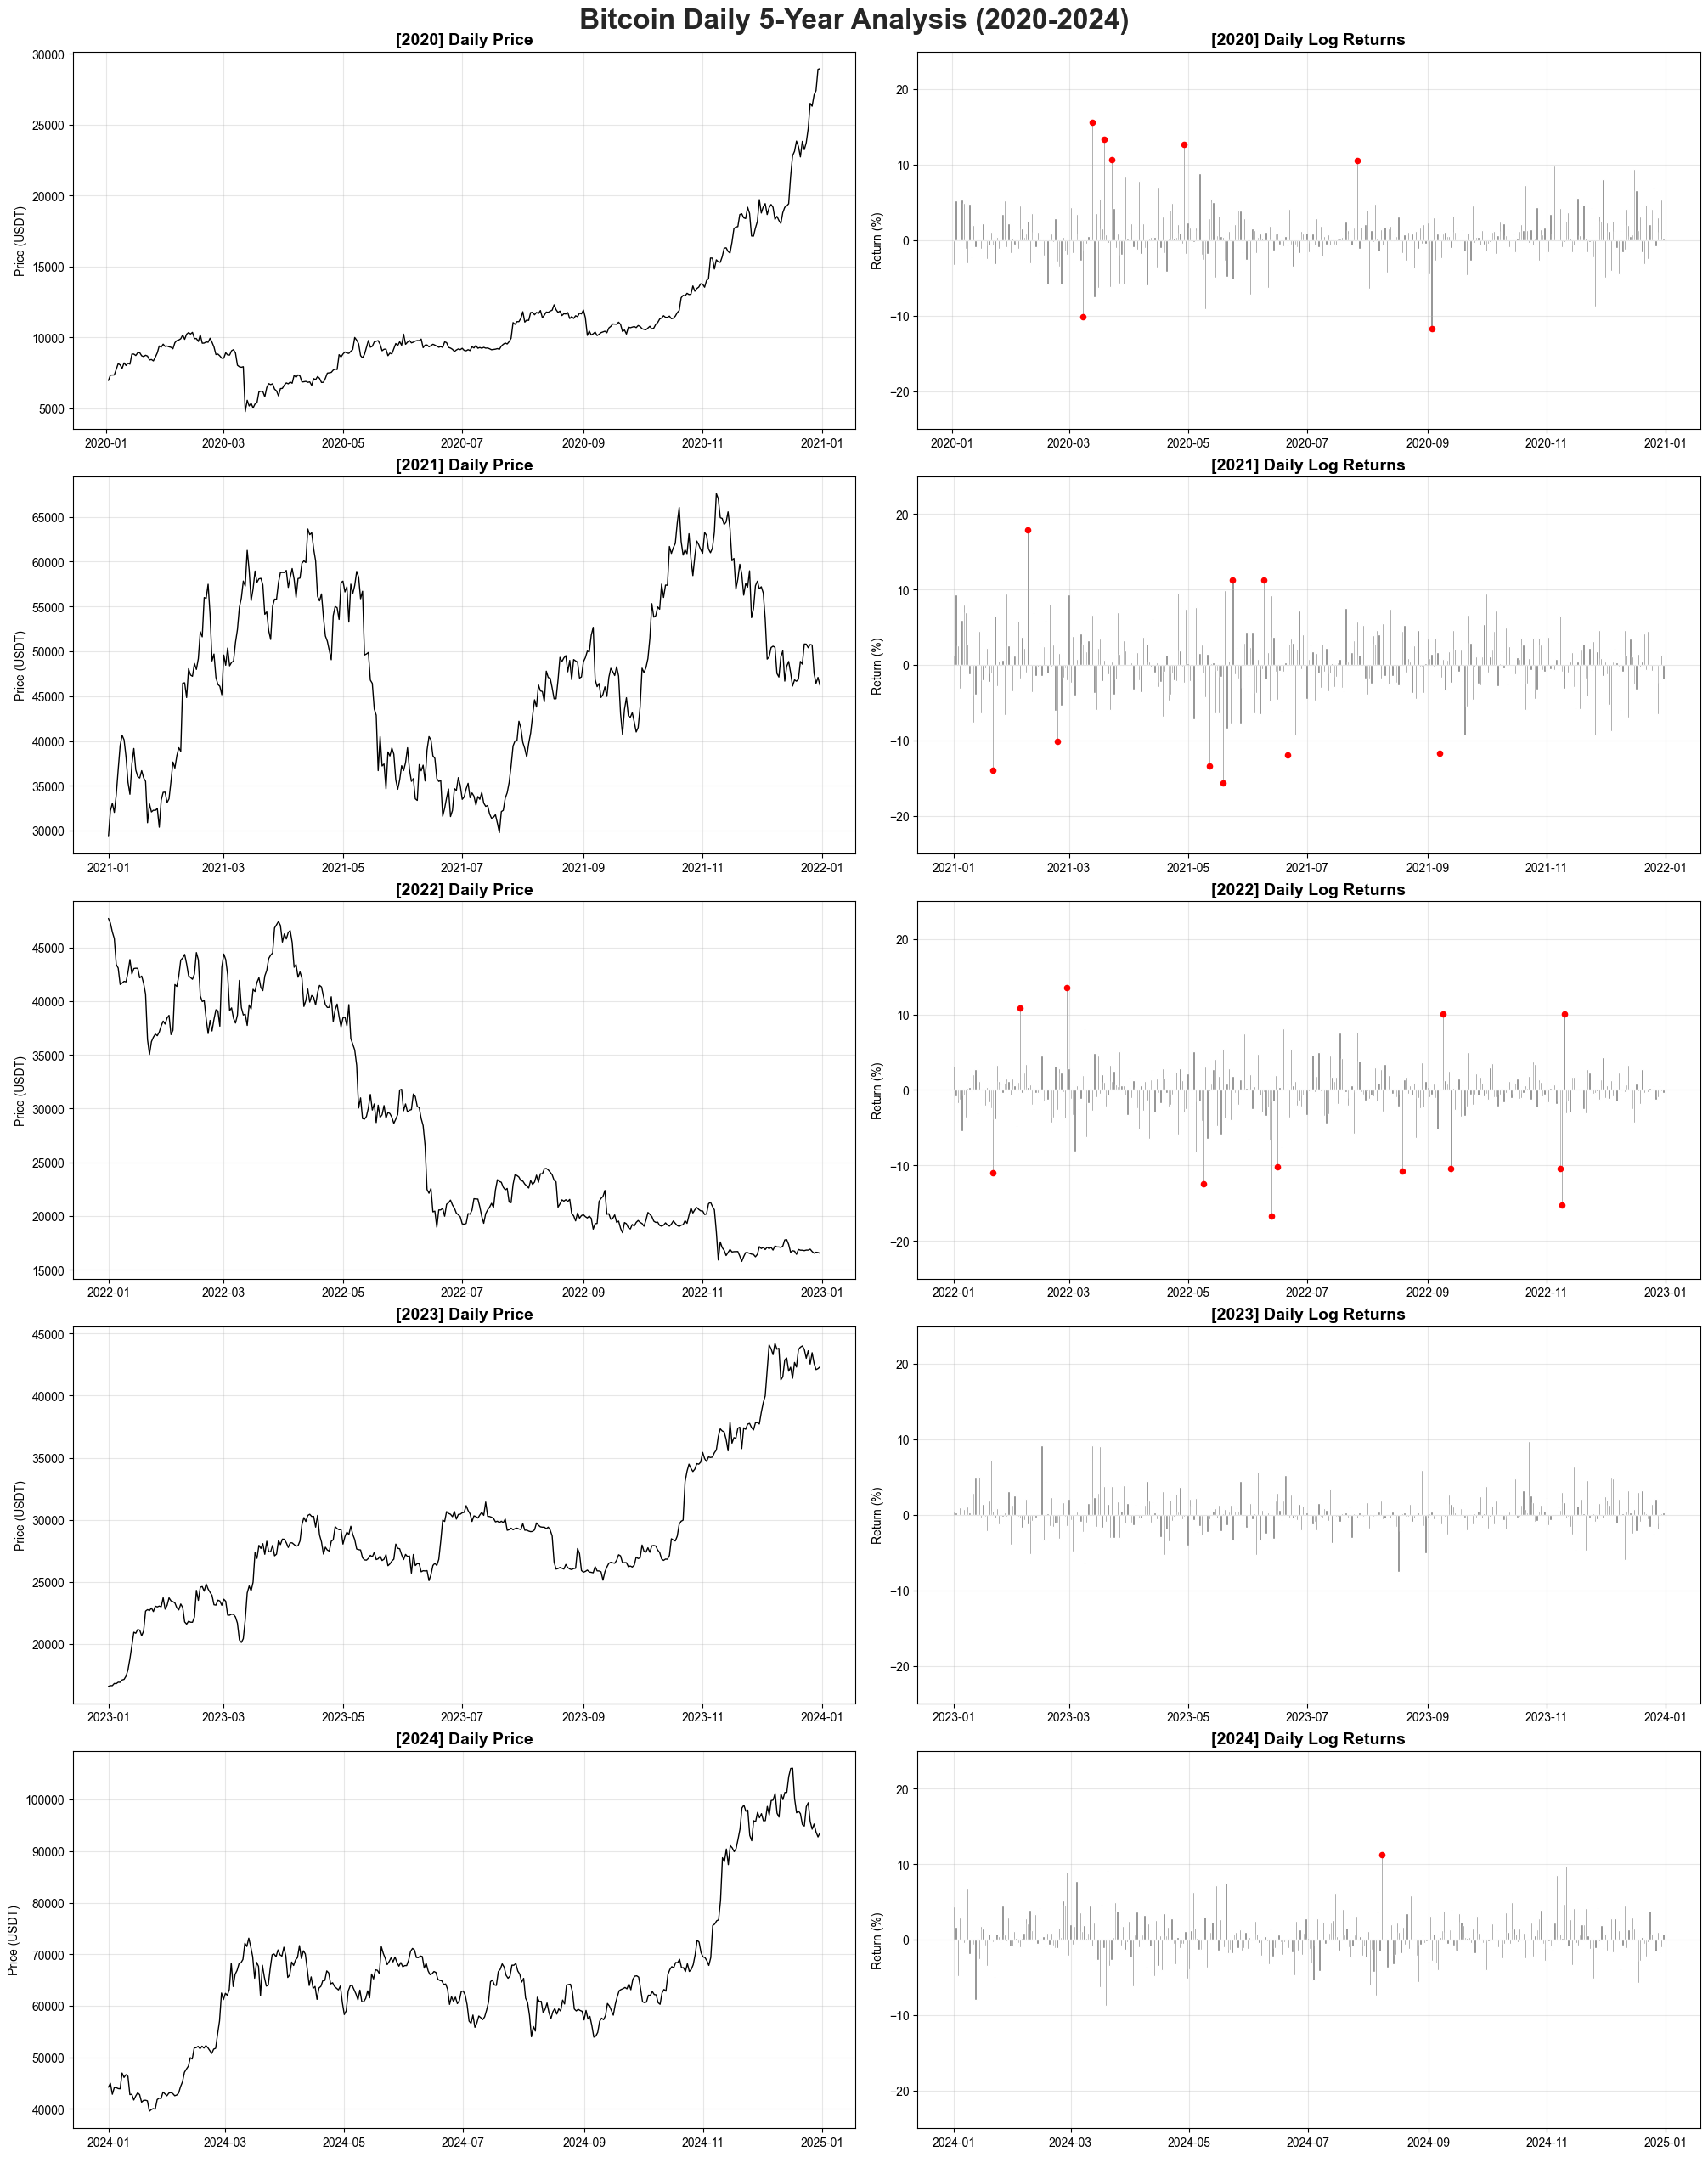

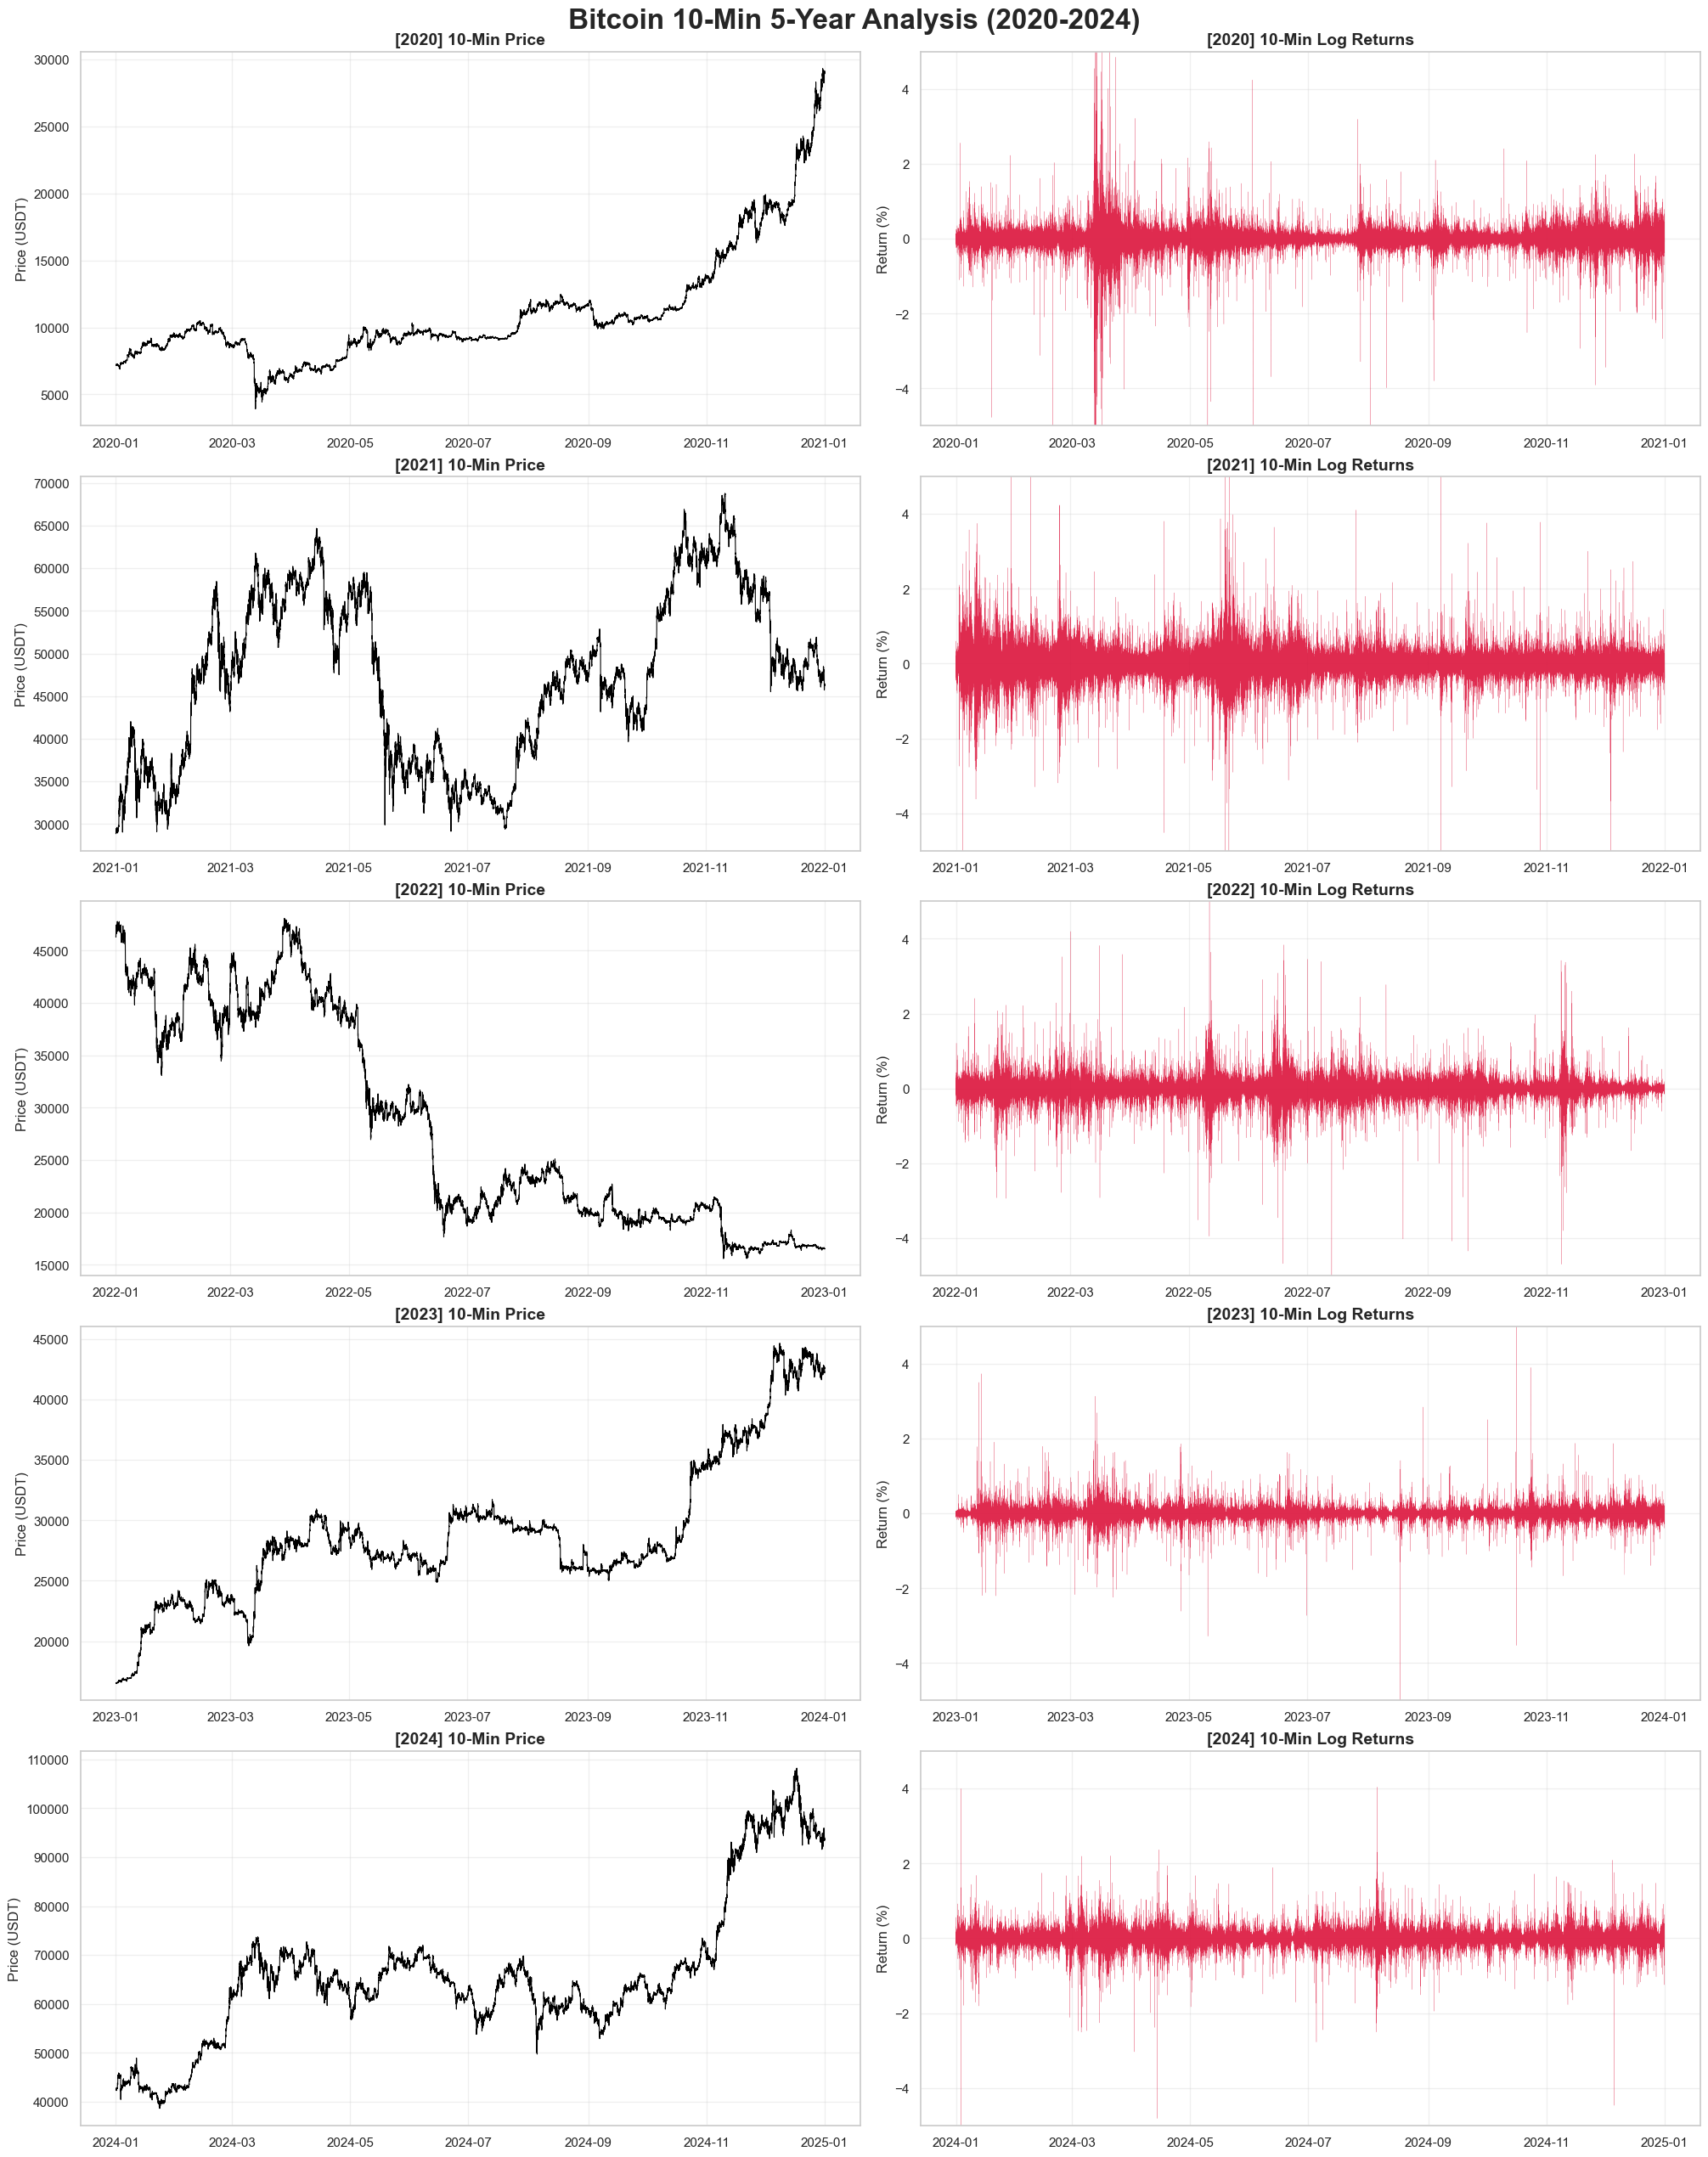

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# =============================================================================
# [설정] 파일 경로 패턴 및 설정 (여기를 본인 파일명에 맞게 수정하세요!)
# =============================================================================
DATA_DIR = "data"  # 데이터 폴더 이름
YEARS = [2020, 2021, 2022, 2023, 2024] # 불러올 연도 리스트

# 파일명 패턴 설정 (중요!)
# 예: data 폴더 안에 "BTC_USDT_1d_2021.csv" 형태로 되어 있다면 아래와 같이 설정
# 만약 파일명이 "BTC-USDT-1d-2021.csv"라면 "_"를 "-"로 바꾸세요.
FILE_PATTERN_DAILY = "BTCUSDT_1d_{year}.csv" 
FILE_PATTERN_10MIN = "BTCUSDT_10m_{year}.csv"

# =============================================================================
# 1. 데이터 로드 및 병합 함수 (5년치 합치기)
# =============================================================================
def load_and_merge_years(freq_type):
    """
    freq_type: '1d' 또는 '10m'
    """
    print(f"\n📂 [{freq_type}] 2020~2024년 데이터 로드 및 병합 시작...")
    
    df_list = []
    
    for year in YEARS:
        # 파일 패턴에 따라 경로 생성
        if freq_type == '1d':
            file_name = FILE_PATTERN_DAILY.format(year=year)
        else:
            file_name = FILE_PATTERN_10MIN.format(year=year)
            
        file_path = os.path.join(DATA_DIR, file_name)
        
        if os.path.exists(file_path):
            print(f"   -> 로드 중: {file_name}")
            try:
                # CSV 읽기 (인덱스가 date나 timestamp라고 가정)
                # 만약 날짜 컬럼명이 'open_time' 등이라면 index_col=0 대신 parse_dates=['open_time'] 등으로 수정 필요
                curr_df = pd.read_csv(file_path, index_col=0, parse_dates=True)
                df_list.append(curr_df)
            except Exception as e:
                print(f"      ❌ 읽기 실패: {e}")
        else:
            print(f"   ⚠️ 파일 없음 (건너뜀): {file_name}")
    
    if not df_list:
        print("❌ 로드된 데이터가 없습니다.")
        return None

    # 1. 데이터 병합 (Concat)
    full_df = pd.concat(df_list)
    
    # 2. 중복 제거 및 정렬 (혹시 겹치는 기간이 있을 경우 대비)
    full_df = full_df[~full_df.index.duplicated(keep='first')]
    full_df.sort_index(inplace=True)
    
    # 3. 필요한 컬럼 확인 ('close')
    # 대소문자 이슈 처리 (Close -> close)
    full_df.rename(columns=lambda x: x.lower(), inplace=True)
    
    if 'close' not in full_df.columns:
        print("❌ 'close' 컬럼을 찾을 수 없습니다.")
        return None
        
    # 4. Log Return 계산
    print(f"   -> Log Return 계산 중... (데이터 크기: {len(full_df):,} 행)")
    full_df['log_return'] = np.log(full_df['close'] / full_df['close'].shift(1)) * 100
    full_df.dropna(inplace=True)
    
    return full_df

# =============================================================================
# 2. 시각화 함수 (Resampling 없이 Raw Data 그리기)
# =============================================================================
def plot_5year_trends(df, freq_name, save_filename):
    # 데이터에 존재하는 연도만 추출
    available_years = sorted(df.index.year.unique())
    n_years = len(available_years)
    
    print(f"🎨 [{freq_name}] 그래프 생성 중 (총 {n_years}년치)...")

    # 캔버스 생성
    fig, axes = plt.subplots(n_years, 2, figsize=(20, 5 * n_years), constrained_layout=True)
    sns.set(style="whitegrid")
    
    if n_years == 1:
        axes = np.expand_dims(axes, axis=0)

    for i, year in enumerate(available_years):
        year_data = df[df.index.year == year]
        
        # --- (왼쪽) 가격 (Price) ---
        ax_price = axes[i, 0]
        ax_price.plot(year_data.index, year_data['close'], 
                      color='black', linewidth=1.0 if freq_name=='Daily' else 0.8)
        
        ax_price.set_title(f"[{year}] {freq_name} Price", fontsize=14, fontweight='bold')
        ax_price.set_ylabel("Price (USDT)")
        ax_price.grid(True, alpha=0.3)
        
        # --- (오른쪽) 로그 수익률 (Log Return) ---
        ax_vol = axes[i, 1]
        
        if freq_name == 'Daily':
            # 일봉: 막대 그래프 + 큰 변동성 강조
            ax_vol.bar(year_data.index, year_data['log_return'], color='gray', width=1.0)
            
            # 10% 이상 변동성 강조
            big_move = year_data[np.abs(year_data['log_return']) > 10]
            ax_vol.scatter(big_move.index, big_move['log_return'], color='red', s=20, zorder=5)
            
            y_limit = 25
            line_width = 1.0
        else:
            # 10분봉: Raw Data 그대로 (Resampling X)
            # 데이터가 많으므로 선을 아주 얇게(0.15) 설정
            ax_vol.plot(year_data.index, year_data['log_return'], 
                        color='crimson', linewidth=0.15, alpha=0.9)
            y_limit = 5 # 10분봉은 보통 ±5% 이내
        
        ax_vol.set_title(f"[{year}] {freq_name} Log Returns", fontsize=14, fontweight='bold')
        ax_vol.set_ylabel("Return (%)")
        ax_vol.set_ylim(-y_limit, y_limit)
        ax_vol.grid(True, alpha=0.3)

    plt.suptitle(f"Bitcoin {freq_name} 5-Year Analysis (2020-2024)", fontsize=24, fontweight='bold', y=1.01)
    
    plt.savefig(save_filename, dpi=200, bbox_inches='tight')
    print(f"   💾 저장 완료: {save_filename}")

# =============================================================================
# 3. 메인 실행
# =============================================================================
if __name__ == "__main__":
    
    # 1. 일별 데이터 (Daily) 처리
    df_daily_all = load_and_merge_years('1d')
    if df_daily_all is not None:
        plot_5year_trends(df_daily_all, "Daily", "BTC_5Year_Trend_Daily.png")
    
    print("-" * 50)
    
    # 2. 10분봉 데이터 (10m) 처리
    # 주의: 데이터가 커서(약 26만 행) 병합 및 시각화에 시간이 조금 걸립니다.
    df_10m_all = load_and_merge_years('10m')
    if df_10m_all is not None:
        plot_5year_trends(df_10m_all, "10-Min", "BTC_5Year_Trend_10min.png")
        
    print("\n✅ 모든 작업 완료!")


📂 [1d] 5년치 데이터 로드 및 병합 중...

📂 [10m] 5년치 데이터 로드 및 병합 중...

⚙️ Log Return 계산 중 (10분봉)...
   -> Price 데이터: 1,827 행 (Daily)
   -> Volatility 데이터: 263,087 행 (10-min)

🎨 5년치 통합 그래프 그리기 시작...

✅ 그래프 저장 완료: BTC_5Year_Panorama_View.png


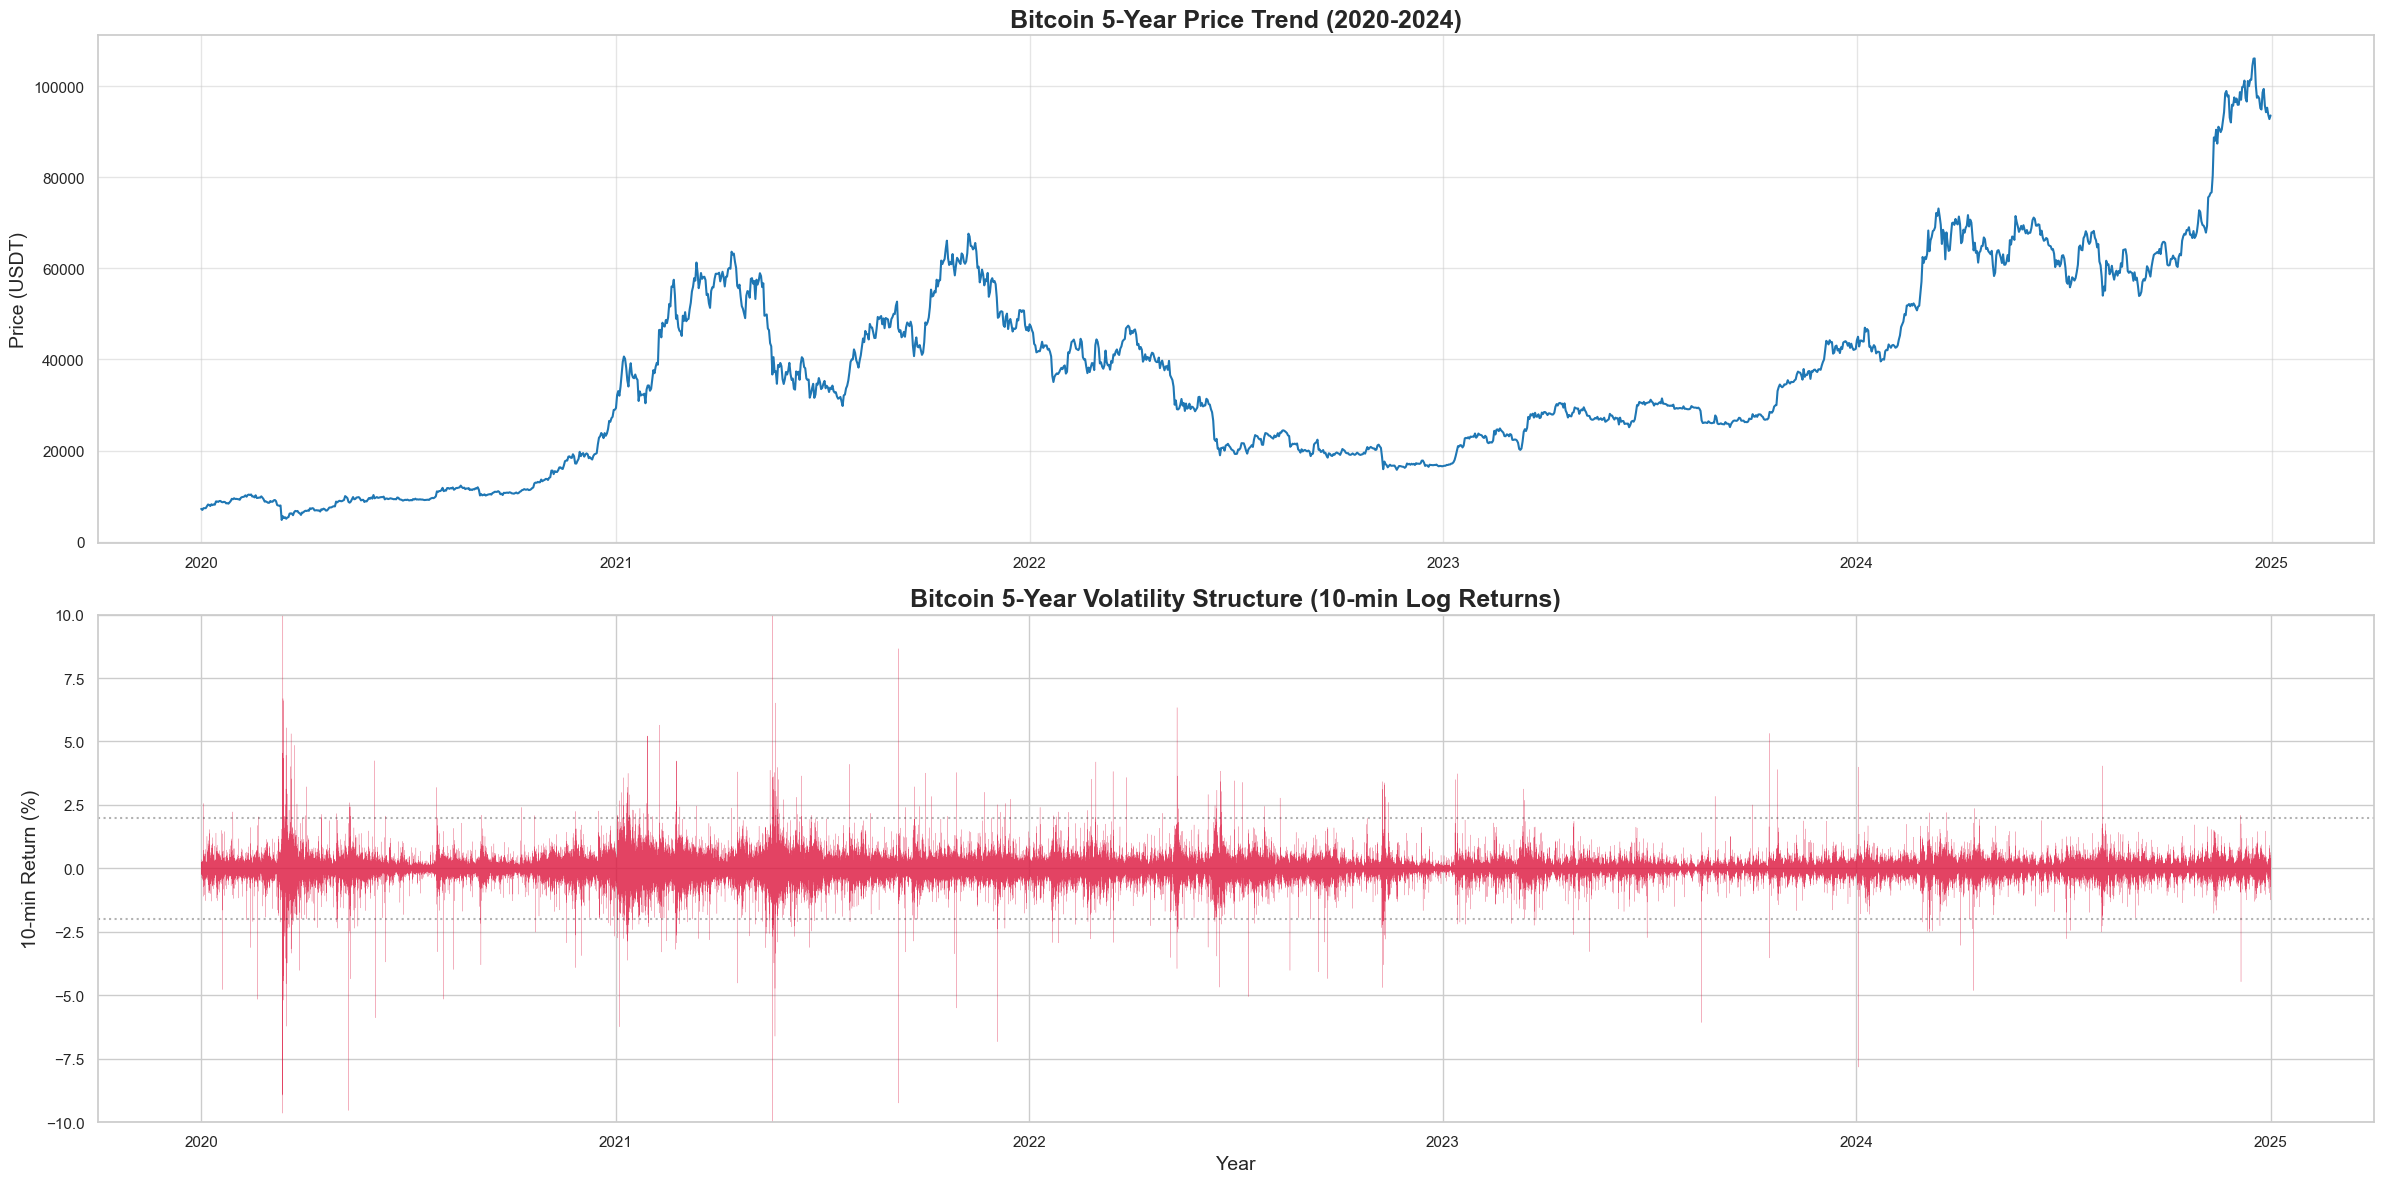

In [5]:

# =============================================================================
# [설정] 파일 경로 및 패턴
# =============================================================================
DATA_DIR = "data"                  # 데이터 폴더명
YEARS = [2020, 2021, 2022, 2023, 2024] # 불러올 연도

# 파일명 패턴 (본인의 파일명에 맞게 수정하세요)
# 예: data/BTC_USDT_1d_2021.csv
FILE_PATTERN_DAILY = "BTCUSDT_1d_{year}.csv" 
FILE_PATTERN_10MIN = "BTCUSDT_10m_{year}.csv"

# =============================================================================
# 1. 데이터 로드 및 병합 함수
# =============================================================================
def load_merge_data(freq_type, years):
    print(f"\n📂 [{freq_type}] 5년치 데이터 로드 및 병합 중...")
    df_list = []
    
    # 파일 패턴 선택
    pattern = FILE_PATTERN_DAILY if freq_type == '1d' else FILE_PATTERN_10MIN
    
    for year in years:
        file_name = pattern.format(year=year)
        file_path = os.path.join(DATA_DIR, file_name)
        
        if os.path.exists(file_path):
            try:
                # 필요한 컬럼만 읽어서 메모리 절약 (Index, Close)
                # 날짜 컬럼이 인덱스가 아닌 경우를 대비해 유연하게 읽기
                df = pd.read_csv(file_path, index_col=0, parse_dates=True)
                
                # 컬럼명 소문자 통일 (Close -> close)
                df.rename(columns=lambda x: x.lower(), inplace=True)
                
                if 'close' in df.columns:
                    df_list.append(df[['close']])
                else:
                    print(f"   ⚠️ 'close' 컬럼 없음: {file_name}")
            except Exception as e:
                print(f"   ❌ 읽기 에러 ({file_name}): {e}")
        else:
            print(f"   ⚠️ 파일 없음: {file_name}")
            
    if not df_list:
        return None
        
    # 병합
    full_df = pd.concat(df_list)
    full_df = full_df[~full_df.index.duplicated(keep='first')] # 중복 제거
    full_df.sort_index(inplace=True)
    
    return full_df

# =============================================================================
# 2. 메인 실행 및 시각화
# =============================================================================
if __name__ == "__main__":
    
    # --- Step 1: 데이터 준비 ---
    
    # (A) Price용: 일별 데이터 (가벼움)
    df_price = load_merge_data('1d', YEARS)
    
    # (B) Volatility용: 10분봉 데이터 (무거움 -> Log Return만 계산)
    df_vol = load_merge_data('10m', YEARS)
    
    if df_price is not None and df_vol is not None:
        print("\n⚙️ Log Return 계산 중 (10분봉)...")
        # 10분봉 기준 로그 수익률 계산
        df_vol['log_return'] = np.log(df_vol['close'] / df_vol['close'].shift(1)) * 100
        df_vol.dropna(inplace=True)
        
        print(f"   -> Price 데이터: {len(df_price):,} 행 (Daily)")
        print(f"   -> Volatility 데이터: {len(df_vol):,} 행 (10-min)")

        # --- Step 2: 그래프 그리기 (파노라마 뷰) ---
        print("\n🎨 5년치 통합 그래프 그리기 시작...")
        
        # 캔버스 설정 (위: 가격, 아래: 변동성)
        fig, axes = plt.subplots(2, 1, figsize=(24, 12), gridspec_kw={'height_ratios': [1, 1]})
        sns.set(style="whitegrid")
        
        # 1. Price Trend (Daily Data 사용)
        ax1 = axes[0]
        ax1.plot(df_price.index, df_price['close'], color='#1f77b4', linewidth=1.5)
        ax1.set_title("Bitcoin 5-Year Price Trend (2020-2024)", fontsize=18, fontweight='bold')
        ax1.set_ylabel("Price (USDT)", fontsize=14)
        ax1.grid(True, which='major', alpha=0.5)
        
        # 주요 구간 텍스트 표시 (옵션)
        # ax1.text(pd.to_datetime('2021-11-10'), 69000, ' ATH (69k)', color='red', fontweight='bold')

        # 2. Volatility Clusters (10-min Log Return 사용)
        ax2 = axes[1]
        # 데이터가 많으므로 선을 아주 얇게(linewidth=0.1) 해서 밀도를 표현
        ax2.plot(df_vol.index, df_vol['log_return'], color='crimson', linewidth=0.15, alpha=0.8)
        
        ax2.set_title("Bitcoin 5-Year Volatility Structure (10-min Log Returns)", fontsize=18, fontweight='bold')
        ax2.set_ylabel("10-min Return (%)", fontsize=14)
        ax2.set_xlabel("Year", fontsize=14)
        
        # Y축 범위 제한 (너무 큰 이상치 때문에 그래프가 납작해지는 것 방지)
        # 보통 10분봉은 ±5% 이내이나, 코로나 빔 같은 때 ±15%까지 감
        ax2.set_ylim(-10, 10) 
        
        # High Volatility Regime 표시 (기준선)
        ax2.axhline(y=2, color='black', linestyle=':', alpha=0.3)
        ax2.axhline(y=-2, color='black', linestyle=':', alpha=0.3)
        
        plt.tight_layout()
        
        # 파일 저장
        save_file = "BTC_5Year_Panorama_View.png"
        plt.savefig(save_file, dpi=300, bbox_inches='tight')
        print(f"\n✅ 그래프 저장 완료: {save_file}")
        
        # plt.show() # 화면 팝업 필요시 주석 해제

    else:
        print("\n❌ 데이터를 로드하지 못했습니다. 파일 경로를 확인해주세요.")